#### import all packages needed

In [1]:
import matplotlib.pyplot as plt
import multiprocess as mp
import numpy as np
import pandas as pd
import pickle
import random
import tqdm.notebook as tqdm
import torch
import skorch.callbacks.base
import os
import sys
sys.path.insert(0, 'cgcnn/')
import cgcnn
import mongo
from cgcnn.data import collate_pool, MergeDataset, StructureDataTransformer, CIFData
from cgcnn.model import CrystalGraphConvNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skorch.callbacks import Checkpoint, LoadInitState 
from skorch.callbacks.lr_scheduler import WarmRestartLR, LRScheduler
from skorch.dataset import ValidSplit
from skorch import NeuralNetRegressor
from torch.optim import Adam, SGD, AdamW

#Select which GPU to use if necessary
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

ModuleNotFoundError: No module named 'matplotlib'

#### Load the cleavage energy docs and convert the structures into graph objects

In [4]:
docs = pickle.load(open('../cleavage_energy_dataset/intermetallics_cleavage_energy_data.pkl' ,'rb'))
random.seed(123)
random.shuffle(docs)

for doc in docs:
    doc["atoms"] = doc['thinnest_structure']['atoms']
    doc["results"] = doc['thinnest_structure']['results']
    doc["initial_configuration"] = doc['thinnest_structure']['initial_configuration']
    del doc["thinnest_structure"]

In [5]:
# original w/ our current path
SDT = StructureDataTransformer(atom_init_loc='./cgcnn/atom_init.json',
                               max_num_nbr=12,
                               step=0.8,
                               radius=4,
                               use_voronoi=False,
                               use_tag=False,
                               use_fixed_info=False,
                               use_distance=False,
                               train_geometry = 'initial'
                               )

SDT_out = SDT.transform(docs)
structures = SDT_out[0]

#Settings necessary to build the model (since they are size of vectors as inputs)
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]

with mp.Pool(16) as pool:
    SDT_list = list(tqdm.tqdm(pool.imap(lambda x: SDT_out[x],range(len(SDT_out)),chunksize=40),total=len(SDT_out)))

  0%|          | 0/3033 [00:00<?, ?it/s]

#### Prepare prediction labels

In [6]:
target_list = np.array([[int(docs.index(doc)), np.log(doc['cleavage_energy'])] for doc in docs])
target_list = pd.DataFrame(target_list, columns = ['doc_index', 'cleavage_energy'])

#### Split data into 80:20 train:test

In [7]:
SDT_training, SDT_test, target_training, target_test = train_test_split(SDT_list, target_list, test_size=0.2, random_state=42)

#### Set up checkpoints

In [16]:
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
else:
    device='cpu'
print(device)
#Make a checkpoint to save parameters every time there is a new best for validation lost
cp = Checkpoint(monitor='valid_loss_best',fn_prefix='valid_best_')

#Callback to load the checkpoint with the best validation loss at the end of training
class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('valid_best_params.pt')
        
load_best_valid_loss = train_end_load_best_valid_loss()

cuda


#### Set up the model and train the model with training data

In [9]:
#further spilt the training data into train and validate set by 8:2 ratio to avoid overfitting
from skorch.dataset import get_len
train_test_splitter = ShuffleSplit(test_size=0.2, random_state=42)
LR_schedule = LRScheduler()

class MyNet(NeuralNetRegressor):
    def get_loss(self, y_pred, y_true, **kwargs):
        y_pred = y_pred[0] if isinstance(y_pred, tuple) else y_pred  # discard the 2nd output
        return super().get_loss(y_pred, y_true, **kwargs)
    def run_single_epoch(self, iterator, training, prefix, step_fn, **fit_params):
        """just one modification with skorch.net run_single_epoch:
            batch[0] -> batch[0]['atom_fea']"""
        if iterator is None:
            return
        batch_count = 0
        for batch in iterator:
            self.notify("on_batch_begin", batch=batch, training=training)
            step = step_fn(batch, **fit_params)
            self.history.record_batch(prefix + "_loss", step["loss"].item())
            batch_size = (get_len(batch[0]['atom_fea']) if isinstance(batch, (tuple, list))
                          else get_len(batch))
            self.history.record_batch(prefix + "_batch_size", batch_size)
            self.notify("on_batch_end", batch=batch, training=training, **step)
            batch_count += 1

        self.history.record(prefix + "_batch_count", batch_count)

## below is the sigopt best assignment
net = MyNet(
    CrystalGraphConvNet,
    module__orig_atom_fea_len = orig_atom_fea_len,
    module__nbr_fea_len = nbr_fea_len,
    batch_size=87,  
    module__classification=False,
    lr=np.exp(-6.465085550816676),     
    max_epochs=300,
    module__atom_fea_len=43,
    module__h_fea_len=114,
    module__n_conv=8,
    module__n_h=3, 
    module__use_distance=False,
    module__cutoff=100,
    optimizer=AdamW,
    optimizer__weight_decay=1e-2,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn = collate_pool,
    iterator_train__shuffle=True, #VERY IMPORTANT
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn = collate_pool,
    iterator_valid__shuffle=False, #This should be False, which is the default
    device=device,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    train_split = ValidSplit(cv=train_test_splitter),
    callbacks=[cp, load_best_valid_loss, LR_schedule]
)

X, y = SDT_training, np.array(target_training[['cleavage_energy']])
net.initialize()
net.fit(X, y)

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, cutoff, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len, use_distance.
Re-initializing criterion.
Re-initializing optimizer.


/public/home/hpc222107/hyu/Cleavage_Energy_Manuscript/train_CGCNN_model/cgcnn/cgcnn/data.py:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  'distances':torch.cat(batch_distances,dim=0)}, torch.FloatTensor(batch_target)


  epoch    train_loss    valid_loss    cp      lr     dur
-------  ------------  ------------  ----  ------  ------
      1        0.8154        3.5384     +  0.0500  9.3376
      2        0.2730        0.2566     +  0.0488  0.7615
      3        0.2496        0.1851     +  0.0452  0.7550
      4        0.2173        0.1811     +  0.0397  0.7599
      5        0.1791        0.3262        0.0327  0.7569
      6        0.1866        0.1600     +  0.0250  0.7531
      7        0.1688        0.1367     +  0.0173  0.7508
      8        0.1564        0.1474        0.0103  0.7520
      9        0.1584        0.1247     +  0.0048  0.7514
     10        0.1408        0.1241     +  0.0012  0.7507
     11        0.1371        0.1243        0.0000  0.7535
     12        0.7403        0.2441        0.0500  0.7680
     13        0.2302        0.1638        0.0497  0.7641
     14        0.1870        0.1870        0.0488  0.7491
     15        0.1623        0.1409        0.0473  0.7487
     16       

<class '__main__.MyNet'>[initialized](
  module_=CrystalGraphConvNet(
    (embedding): Linear(in_features=92, out_features=43, bias=True)
    (convs): ModuleList(
      (0-7): 8 x ConvLayer(
        (fc_full): Linear(in_features=92, out_features=86, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1.0, threshold=20.0)
        (bn1): BatchNorm1d(86, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(43, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(beta=1.0, threshold=20.0)
      )
    )
    (conv_to_fc): Linear(in_features=43, out_features=114, bias=True)
    (conv_to_fc_softplus): Softplus(beta=1.0, threshold=20.0)
    (fcs): ModuleList(
      (0-1): 2 x Linear(in_features=114, out_features=114, bias=True)
    )
    (softpluses): ModuleList(
      (0-1): 2 x Softplus(beta=1.0, threshold=20.0)
    )
    (bn): ModuleList(
      (0-1): 2 x BatchNorm1d(114, eps=1e-05, momentum

#### Make predictions and visualize the predictions with parity plot

In [13]:
training_data = {'doc_index': list(target_training['doc_index']),
                 'type': 'train', 
                 'actual_value':np.exp(target_training['cleavage_energy']),
                 'predicted_value':np.exp(net.predict(SDT_training).reshape(-1))}

test_data = {'doc_index': list(target_test['doc_index']),
             'type': 'test',
            'actual_value':np.exp(target_test['cleavage_energy']),
            'predicted_value':np.exp(net.predict(SDT_test).reshape(-1))}


df_training = pd.DataFrame(training_data)
df_test = pd.DataFrame(test_data)

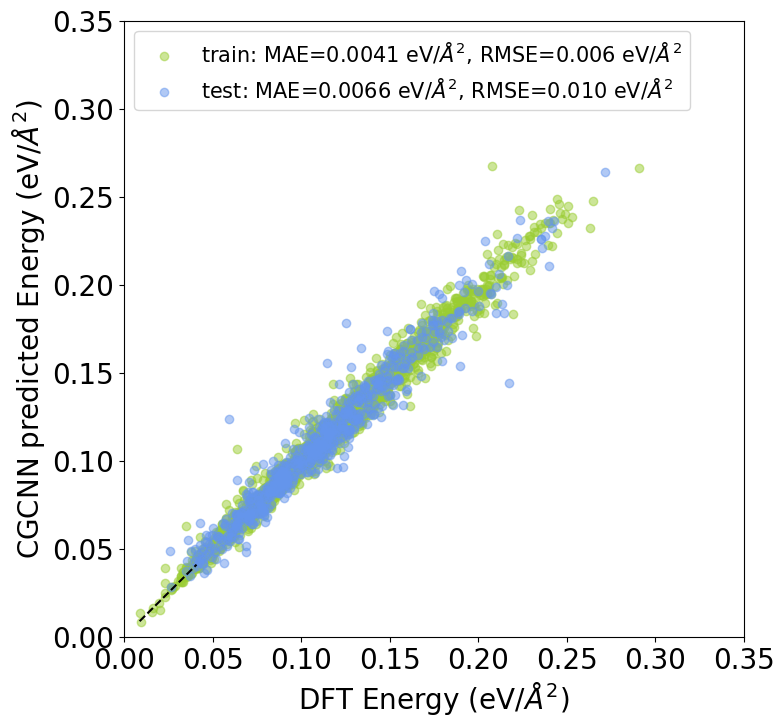

In [14]:
f, ax = plt.subplots(figsize=(8,8))
ax.scatter(df_training['actual_value'], df_training['predicted_value'], color='yellowgreen', 
           marker='o', alpha=0.5, label='train: MAE=%0.4f eV/$\AA^2$, RMSE=%0.3f eV/$\AA^2$'\
            %(mean_absolute_error(df_training['actual_value'], df_training['predicted_value']), 
              np.sqrt(mean_squared_error(df_training['actual_value'], df_training['predicted_value']))))

ax.scatter(df_test['actual_value'], df_test['predicted_value'], color='cornflowerblue', 
           marker='o', alpha=0.5, label='test: MAE=%0.4f eV/$\AA^2$, RMSE=%0.3f eV/$\AA^2$'\
            %(mean_absolute_error(df_test['actual_value'], df_test['predicted_value']), 
              np.sqrt(mean_squared_error(df_test['actual_value'], df_test['predicted_value']))))

ax.plot([min(df_training['actual_value']), max(df_training['actual_value'])-0.25], 
        [min(df_training['actual_value']), max(df_training['actual_value'])-0.25], 'k--')

# format graph
ax.tick_params(labelsize=20)
ax.set_xlabel('DFT Energy (eV/$\AA^2$)', fontsize=20)
ax.set_ylabel('CGCNN predicted Energy (eV/$\AA^2$)', fontsize=20)
ax.set_xlim(0,0.35)
ax.set_ylim(0,0.35)
#ax.set_title('Multi-element ', fontsize=14) 
ax.legend(fontsize=15, loc='upper left')

plt.show()

In [41]:
import ase.io
importlib.reload(mongo)
Cu_100 = ase.io.read("../CZA/Cu_Slabs/Cu_100.cif")

print(type(Cu_100))
dd = mongo.make_doc_from_atoms(Cu_100)

for doc in dd:
    doc["atoms"] = doc['thinnest_structure']['atoms']
    doc["results"] = doc['thinnest_structure']['results']
    doc["initial_configuration"] = doc['thinnest_structure']['initial_configuration']
    del doc["thinnest_structure"]

<class 'ase.atoms.Atoms'>


AttributeError: 'Atoms' object has no attribute 'lattice'

In [33]:
result = np.exp(net.predict(SDT_test).reshape(-1))
# print(result)
for i in range(len(SDT_test[0])):
    print(SDT_test[0][i].shape, Cu_slabs[0][i].shape)
    print(SDT_test[0][i],"\n", Cu_slabs[0][i])

net.load_params("./valid_best_params.pt")
np.exp(net.predict(Cu_slabs).reshape(-1))

<class 'list'> <class 'list'>
torch.Size([16, 92]) torch.Size([5, 92])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) 
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

RuntimeError: mat1 and mat2 shapes cannot be multiplied (228x127 and 92x86)

#### Get atomic contributions trajectories

We picked the ones witCu_slabseasonably accurate prediction as an example, but you can loop through the test data index and make trajectories of atomic contriution for all test data. 

In [ ]:
visual_idx = np.where(np.array((abs(df_test['actual_value'] - df_test['predicted_value']))) < 0.00005)[0]

for idx in visual_idx:
    doc_idx = int(df_test.iloc[idx]['doc_index']) 
    out, atom_fea = net.forward([SDT_list[doc_idx]])
    contributions = atom_fea.cpu().data.numpy().reshape(-1)
    atoms = mongo.make_atoms_from_doc(docs[doc_idx])
    atoms.set_initial_charges(np.exp(contributions))
    atoms.write('./Traj/docs_%d.traj'%(doc_idx))

In [20]:
from ase.io.trajectory import Trajectory
from ase.visualize import view

traj = Trajectory('./Traj/docs_479.traj')
view(traj[-1], viewer='x3d')

In [21]:
np.sum(traj[-1].get_initial_charges())

3.582899756729603

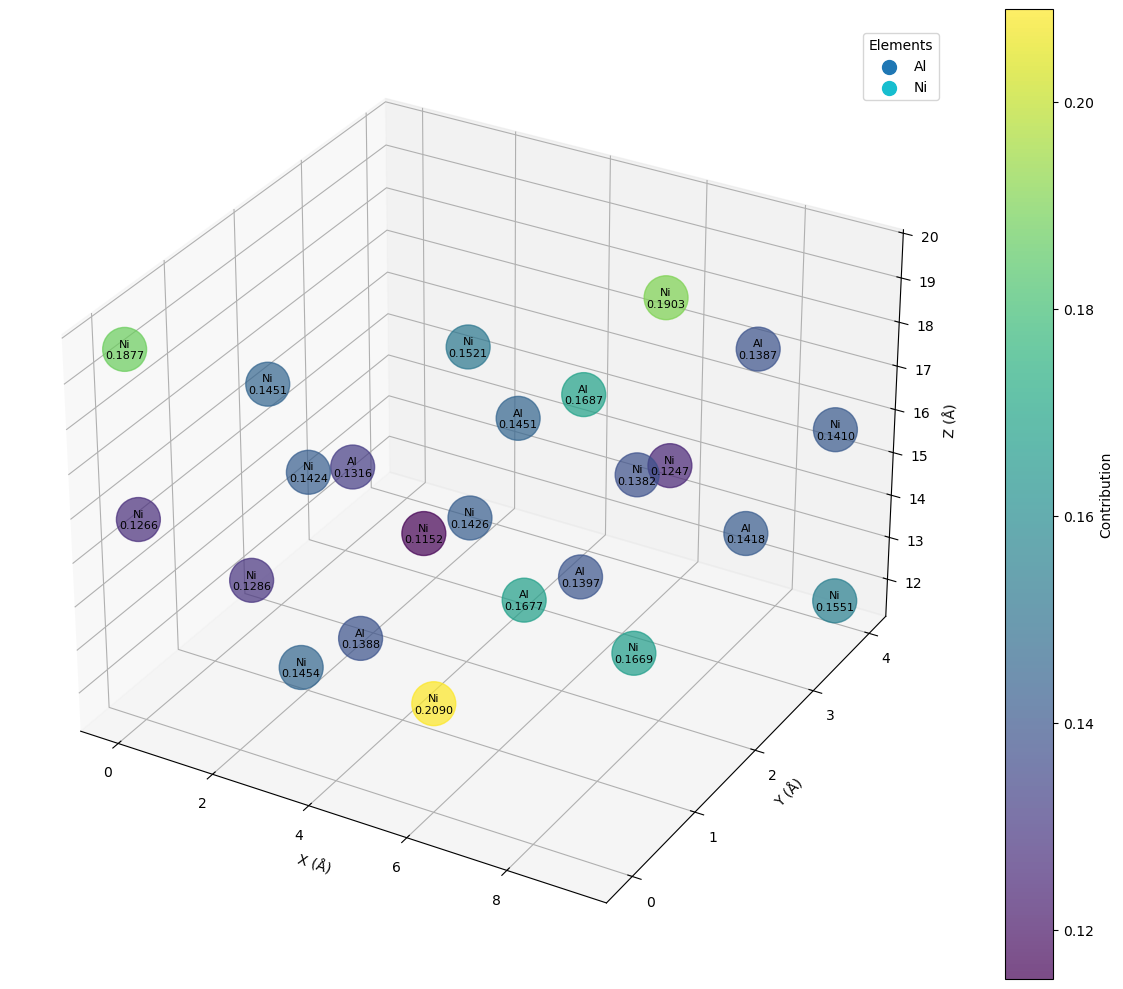

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_atomic_contributions(atoms, contributions):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 获取原子位置和元素符号
    positions = atoms.get_positions()
    symbols = atoms.get_chemical_symbols()
    
    # 为不同元素设置不同的颜色
    unique_symbols = list(set(symbols))
    colors = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_symbols)))
    color_dict = dict(zip(unique_symbols, colors))
    
    # 绘制原子
    scatter = ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2],
                         c=contributions, cmap='viridis', s=1000, alpha=0.7)
    
    # 添加元素符号和贡献值标签
    for sym, pos, contrib in zip(symbols, positions, contributions):
        ax.text(pos[0], pos[1], pos[2], f'{sym}\n{contrib:.4f}', ha='center', va='center', fontsize=8)
    
    # 设置坐标轴
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    
    # 添加图例
    for sym, color in color_dict.items():
        ax.scatter([], [], [], c=[color], label=sym, s=100)
    ax.legend(title='Elements', loc='best')
    
    # 添加颜色条
    fig.colorbar(scatter, ax=ax, label='Contribution')
    
    plt.tight_layout()
    plt.show()

# 调用绘图函数
plot_atomic_contributions(traj[-1], traj[-1].get_initial_charges())

shape factor: 4.954, anisotropy: 0.033, weighted surface energy: 0.214 eV/Å2


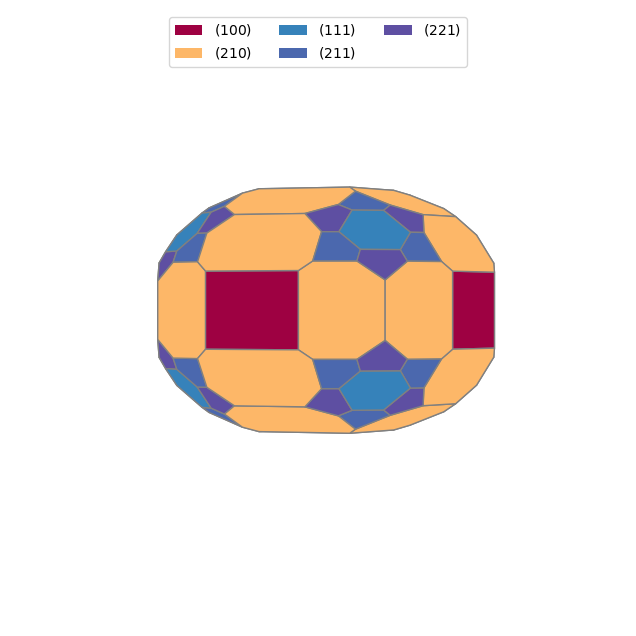

In [71]:

# Import the necessary tools for making a Wulff shape
from pymatgen.analysis.wulff import WulffShape

# Import the necessary tools to generate surfaces
from pymatgen.core.surface import Lattice, SlabGenerator, Structure, generate_all_slabs

a = 1
lattice = Lattice.cubic(a)

# Surface energy values in J/m^2
surface_energies = {
    (1, 0, 0): 0.205,
    (2, 1, 0): 0.212,
    (1, 1, 1): 0.225,
    (1, 1, 0): 0.226,
    (2, 1, 1): 0.226,
    (2, 2, 1): 0.227
}
miller_list = surface_energies.keys()
e_surf_list = surface_energies.values()

# We can now construct a Wulff shape with an accuracy up to a max Miller index of 3
wulffshape = WulffShape(lattice, miller_list, e_surf_list)

# Let's get some useful information from our wulffshape object
print(
    "shape factor: %.3f, anisotropy: \
%.3f, weighted surface energy: %.3f eV/Å2"
    % (
        wulffshape.shape_factor,
        wulffshape.anisotropy,
        wulffshape.weighted_surface_energy,
    )
)

# If we want to see what our Wulff shape looks like
wulffshape.get_plot(color_set="Spectral")
plt.savefig('wulff_plot.png', format='png',dpi=800)

shape factor: 4.954, anisotropy: 0.033, weighted surface energy: 0.214 eV/Å2


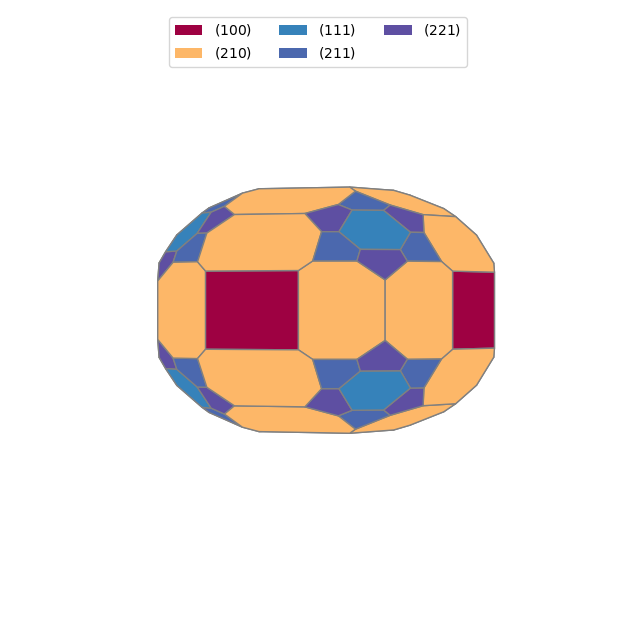

In [72]:

a = 3.155
lattice = Lattice.cubic(a)
# Surface energy values in J/m^2
surface_energies = {
    (1, 0, 0): 0.205,
    (2, 1, 0): 0.212,
    (1, 1, 1): 0.225,
    (1, 1, 0): 0.226,
    (2, 1, 1): 0.226,
    (2, 2, 1): 0.227
}
miller_list = surface_energies.keys()
e_surf_list = surface_energies.values()

# We can now construct a Wulff shape with an accuracy up to a max Miller index of 3
wulffshape = WulffShape(lattice, miller_list, e_surf_list)

# Let's get some useful information from our wulffshape object
print(
    "shape factor: %.3f, anisotropy: \
%.3f, weighted surface energy: %.3f eV/Å2"
    % (
        wulffshape.shape_factor,
        wulffshape.anisotropy,
        wulffshape.weighted_surface_energy,
    )
)

# If we want to see what our Wulff shape looks like
wulffshape.get_plot(color_set="Spectral")
plt.savefig('wulff_plot.png', format='png',dpi=800)

shape factor: 7.183, anisotropy: 0.034, weighted surface energy: 0.221 eV/Å2


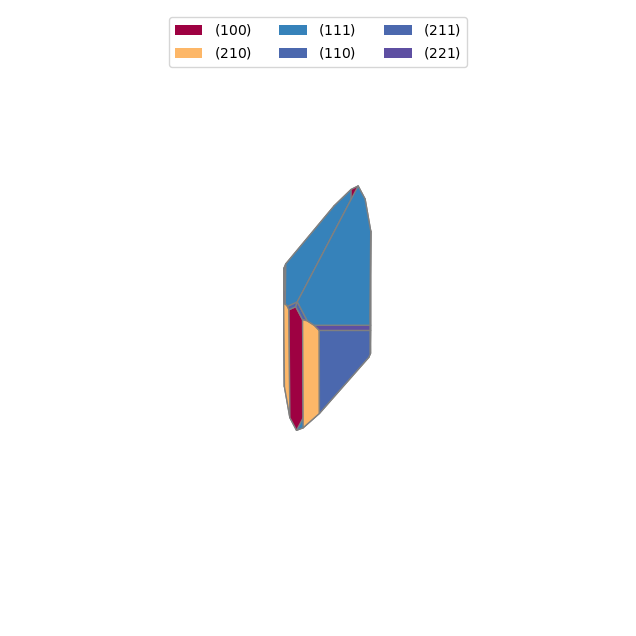

In [68]:
a = 5.0  # 晶格常数a
b = 6.0  # 晶格常数b
c = 7.0  # 晶格常数c
alpha = 90  # 角度α
beta = 110  # 角度β
gamma = 90  # 角度γ

lattice = Lattice.from_parameters(a, b, c, alpha, beta, gamma)

# Surface energy values in J/m^2
surface_energies = {
    (1, 0, 0): 0.205,
    (2, 1, 0): 0.212,
    (1, 1, 1): 0.225,
    (1, 1, 0): 0.226,
    (2, 1, 1): 0.226,
    (2, 2, 1): 0.227
}
miller_list = surface_energies.keys()
e_surf_list = surface_energies.values()

# We can now construct a Wulff shape with an accuracy up to a max Miller index of 3
wulffshape = WulffShape(lattice, miller_list, e_surf_list)

# Let's get some useful information from our wulffshape object
print(
    "shape factor: %.3f, anisotropy: \
%.3f, weighted surface energy: %.3f eV/Å2"
    % (
        wulffshape.shape_factor,
        wulffshape.anisotropy,
        wulffshape.weighted_surface_energy,
    )
)

# If we want to see what our Wulff shape looks like
wulffshape.get_plot(color_set="Spectral")
plt.savefig('wulff_plot.png', format='png',dpi=800)